In [2]:
using Pkg
Pkg.status()
using Plots
using DifferentialEquations

Status `~/.julia/environments/v1.4/Project.toml`
  [c52e3926] Atom v0.12.18
  [31c24e10] Distributions v0.23.5
  [7073ff75] IJulia v1.21.2
  [e5e0dc1b] Juno v0.8.2
  [91a5bcdd] Plots v1.5.6


ArgumentError: ArgumentError: Package DifferentialEquations not found in current path:
- Run `import Pkg; Pkg.add("DifferentialEquations")` to install the DifferentialEquations package.


In [2]:
#----------------------------------------------
# Set Parameters:
#----------------------------------------------

# Membrane capacitance and potential
C_m = 1.0 
V_m = -65.0

# Max sodium conductance and membrane potential
g_Na = 120.0
V_Na = 56.0

# Max potassium conductance and membrane potential
g_K = 36.0
V_K = -77.0 

# Max leak conductance and membrane potential
g_l = 0.3 
V_l = -60.0

# Time to integrate over
time = 0.0:0.1:1000

# ion variables 
m = 0.05
h = 0.6
n = 0.32

0.32

In [12]:
#----------------------------------------------
# Potassium Rate Functoins
#----------------------------------------------
a_n(V_m) =  0.01 * (V_m + 55) / (1 - exp(-(V_m + 55.0) / 10))   

B_n(V_m) = 0.125 * exp(-(V_m + 65.0) / 80)


#----------------------------------------------
# Sodium Rate Functions
#----------------------------------------------

a_m(V_m) = 0.1 * (40 + V_m) / (1.0 - exp(-(V_m + 40.0) / 10.0))

a_h(V_m) = 0.07 * exp(-(V_m + 65.0) / 20.0)

B_m(V_m) = 4 * exp(-(V_m + 65.0) / 18.0)

B_h(V_m) = 1 / (exp(-(35 + V_m) / 10) + 1)


#----------------------------------------------
# Ion Currents
#----------------------------------------------

IK(g_K, n, V_m, V_K) = g_K * n^(4) * (V_m - V_K)

INa(g_Na, m, h, V_m, V_Na) =  g_Na * m^(3) * h * (V_m - V_Na)

LI(g_l, V_m, V_l) = g_l * (V_m - V_l)


#----------------------------------------------
# Input Current
#----------------------------------------------

I_Inj = 20

input(t::AbstractFloat) = ifelse(0 < t < 200, zero(t), ifelse(200<t<300, one(t)*I_Inj, zero(t)))

input (generic function with 1 method)

In [13]:
#----------------------------------------------
# Hodking Huxley model
#----------------------------------------------

function hodgkin_huxley!(du, u, p, t)
    # dVdt, dndt, dmdt, dhdt = u
    #
    #
    V_m, n, m, h = u
    g_K, V_K, g_Na, V_Na, g_l, C_m = p
    
    # Total current through the membrane    
    du[1] = input(t) - IK(g_K,n,V_m,V_K) - INa(g_Na, m, h, V_m, V_Na) - LI(g_l, V_m, V_l) / C_m
 
    # Derivative of n, potassium channel activation, w.r.t. time
    du[2] = a_n(V_m) * (1 - n) - B_n(V_m) * n

    # Derivative of m, sodium channel activion, w.r.t. time
    du[3] = a_m(V_m) * (1 - m) - B_m(V_m) * m

    # Derivative of h, leaky channel in-activion, w.r.t. time

    du[4] = a_h(V_m) * (1 - h) - B_h(V_m) * h
        
end

hodgkin_huxley! (generic function with 1 method)

In [16]:
#----------------------------------------------
# Define ODE problem
#----------------------------------------------


p = [g_K, V_K, g_Na, V_Na, g_l, C_m]
u0 = [V_m, n, m, h]
tspan = (0.0,500.0)

prob = ODEProblem(hodgkin_huxley!,u0,tspan,p)
sol = solve(prob)

retcode: Success
Interpolation: automatic order switching interpolation
t: 1229-element Array{Float64,1}:
   0.0
   0.09986687637950459
   0.22351208208468304
   0.3826324745334655
   0.5767863783920297
   0.8175621254711858
   1.1145580167857387
   1.4966527260676707
   2.3161157099713443
   2.730551102323372
   3.315420153370979
   3.934902629855777
   4.653782829498802
   ⋮
 335.5074348039845
 339.30215444081693
 343.28399781684493
 348.50311490444426
 354.78478673413457
 363.04309894486937
 373.32731527566517
 388.1673034117416
 409.7081425893303
 443.81147374490894
 497.37955531024
 500.0
u: 1229-element Array{Array{Float64,1},1}:
 [-65.0, 0.32, 0.05, 0.6]
 [-65.18416033619569, 0.31993189671551087, 0.05079831024819202, 0.5999929473143448]
 [-65.3910508214751, 0.3197826420902744, 0.05092235554102872, 0.600082276832647]
 [-65.63350367738829, 0.31949784538019704, 0.05032777200044391, 0.6003387379282038]
 [-65.90320591715864, 0.3190271408405791, 0.04911246517484669, 0.6008423197760792

┌ Info: Saved animation to 
│   fn = /Volumes/Pavan_SSD/neuronal_models/julia_models/tmp.gif
└ @ Plots /Users/pavanchaggar/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/Volumes/Pavan_SSD/neuronal_models/julia_models/tmp.gif")
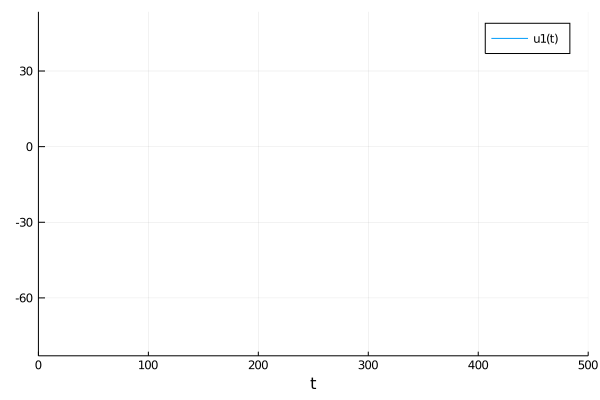

In [17]:
plot(sol, vars=1)
animate(sol, vars=(1), every=20)

┌ Info: Saved animation to 
│   fn = /Volumes/Pavan_SSD/neuronal_models/julia_models/tmp.gif
└ @ Plots /Users/pavanchaggar/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/Volumes/Pavan_SSD/neuronal_models/julia_models/tmp.gif")
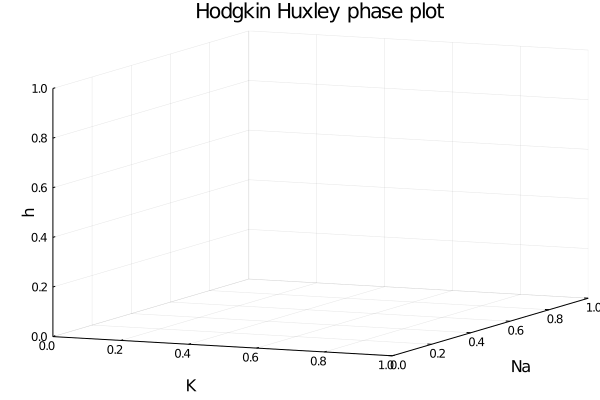

In [43]:
plt = plot3d(
    1,
    xlim = (0,1),
    ylim = (0,1),
    zlim = (0,1),
    title = "Hodgkin Huxley phase plot",
    xlabel = "K",
    ylabel = "Na",
    zlabel = "h",
    label = ""
)

@gif for i=1:1229
    push!(plt, sol.u[i][2], sol.u[i][3],sol.u[i][4])
    end every 50

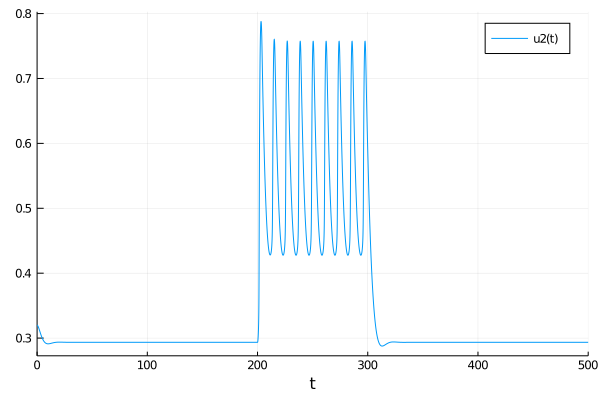

In [41]:
plot(sol, vars=(2))

┌ Info: Saved animation to 
│   fn = /Volumes/Pavan_SSD/neuronal_models/julia_models/tmp.gif
└ @ Plots /Users/pavanchaggar/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/Volumes/Pavan_SSD/neuronal_models/julia_models/tmp.gif")
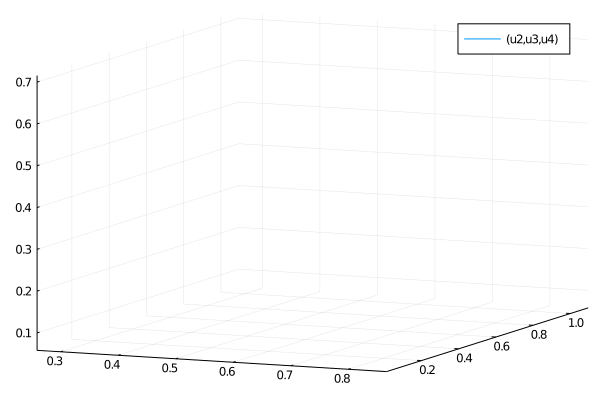

In [20]:
animate(sol, vars=(2,3,4), every=100)